# Lab 1 Task 1

## 1. Implement the following layers as Python functions (both forward and backward propagation)
* Inner-product layer
* Activation layer(Sigmoid or Rectified)
* Softmax layer

In [12]:
# from google.colab import drive
# drive.mount('/content/drive')

In [13]:
# %cd /content/drive/MyDrive/AI_Lab1

In [24]:
import os
from typing import Callable, Iterable
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [25]:
class Parameter:
    def __init__(self, data: np.ndarray) -> None:
        self.data = data
        self.grad = None


class Module:
    def __call__(self, *args, **kwargs) -> np.ndarray:
        return self.forward(*args, **kwargs)

    def __repr__(self) -> str:
        layers = '\n'.join([f'  ({k}): {v}' for k, v in self.__dict__.items()])
        return f'{self.__class__.__name__}(\n{layers}\n)'

In [26]:
class Linear(Module):
    def __init__(self, in_features, out_features) -> None:
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features

        # Initialize weights and biases
        init_factor = 0.01
        self.W = Parameter(np.random.randn(in_features, out_features) * init_factor)
        self.b = Parameter(np.zeros((1, out_features)))

        # Cache for backward pass
        self.x = None

    def forward(self, x):
        # 學生實作部分：reutrn output of linear layer
        self.x = x
        return np.dot(x, self.W.data) + self.b.data

    def backward(self, dy):
        # 學生實作部分：return gradient w.r.t. input and compute gradients for weights and biases
        self.W.grad = np.dot(self.x.T, dy)
        self.b.grad = np.sum(dy, axis=0, keepdims=True)
        return np.dot(dy, self.W.data.T)    

    def parameters(self):
        return self.W, self.b

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}(in_features={self.in_features}, out_features={self.out_features})'


class ReLU(Module):
    def __init__(self) -> None:
        super().__init__()
        self.x = None

    def forward(self, x):
        # 學生實作部分：return output of ReLU activation
        self.x = x
        return np.maximum(0, x)

    def backward(self, dy):
        # 學生實作部分：return gradient w.r.t. input
        return dy * (self.x > 0)

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}()'


class Sigmoid(Module):
    def __init__(self) -> None:
        super().__init__()
        self.y = None

    def forward(self, x):
        # 學生實作部分：return output of Sigmoid activation
        self.x = x
        return 1 / (1 + np.exp(-x))


    def backward(self, dy):
        # 學生實作部分：return gradient w.r.t. input
        sigmoid_x = self.forward(self.x)
        return dy * sigmoid_x * (1 - sigmoid_x)


    def __repr__(self) -> str:
        return f'{self.__class__.__name__}()'


class Softmax(Module):
    def __init__(self) -> None:
        super().__init__()
        self.y = None

    def forward(self, x):
        # 學生實作部分：return output of Softmax activation
        self.x = x
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)


    def backward(self, dy):
        # 這邊我們設定同學們會將Softmax和Cross-Entropy Loss一起使用
        # 因此backward pass根據講義上的說明使用簡化的版本在Cross-Entropy Loss的部分完成
        # 若同學的softmax沒有和Cross-Entropy Loss一起使用，請自行實作完整的backward pass
        return dy

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}()'

In [27]:
class MLP(Module):
    def __init__(self) -> None:
        # 學生實作部分：design your Model architecture here
        super().__init__()

        self.fc1 = Linear(784, 256)    # 第一層：784 → 256
        self.relu1 = ReLU()
        self.fc2 = Linear(256, 128)    # 第二層：256 → 128
        self.relu2 = ReLU()
        self.fc3 = Linear(128, 64)     # 第三層：128 → 64
        self.relu3 = ReLU()
        self.fc4 = Linear(64, 10)      # 輸出層：64 → 10
        self.softmax = Softmax()

    def forward(self, x):
        # 學生實作部分：compute forward pass through your model
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        x = self.softmax(x)
        return x

    def backward(self, dy):
        # 學生實作部分：compute backward pass through your model
        dy = self.softmax.backward(dy)
        dy = self.fc4.backward(dy)
        dy = self.relu3.backward(dy)
        dy = self.fc3.backward(dy)
        dy = self.relu2.backward(dy)
        dy = self.fc2.backward(dy)
        dy = self.relu1.backward(dy)
        dy = self.fc1.backward(dy)
        return dy

    def parameters(self):
        return self.fc1.parameters() + self.fc2.parameters() + self.fc3.parameters() + self.fc4.parameters()

## 2. Implement training and testing process
* included cross-validation

In [47]:
class MNIST:
    # root請根據你的檔案位置更改
    def __init__(self, root='/data', train=True, transform: Callable = None) -> None:
        path = os.path.join(root, 'mnist_train.csv' if train else 'mnist_test.csv')
        self.data = np.loadtxt(path, delimiter=',')
        self.transform = transform
        self.image_size = 28
        self.num_classes = 10
        self.classes = np.arange(self.num_classes)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        label = (self.data[idx, 0] == self.classes).astype(
            np.float32
        )  # one-hot encoding
        image = (
            self.data[idx, 1:]
            .reshape(self.image_size * self.image_size)
            .astype(np.float32)
        )
        if self.transform:
            image = self.transform(image)
        return image, label


class Subset:
    def __init__(self, dataset, indices: Iterable) -> None:
        self.dataset = dataset
        self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        return self.dataset[self.indices[idx]]


class DataLoader:
    def __init__(self, dataset, batch_size=1) -> None:
        self.dataset = dataset
        self.batch_size = batch_size
        self.indices = np.arange(len(dataset))

    def __len__(self):
        return (len(self.dataset) + self.batch_size - 1) // self.batch_size

    def __iter__(self):
        np.random.shuffle(self.indices)
        for start_idx in range(0, len(self.dataset), self.batch_size):
            end_idx = min(start_idx + self.batch_size, len(self.dataset))
            batch_indices = self.indices[start_idx:end_idx]

            batch_images = []
            batch_labels = []

            for idx in batch_indices:
                image, label = self.dataset[idx]
                batch_images.append(image)
                batch_labels.append(label)

            yield np.array(batch_images), np.array(batch_labels)

In [48]:
# Separate train_imgs, train_labels into training and validation
# root請根據你的檔案位置更改
def load_mnist_data(
    root="/data", batch_size=1, split_ratio=0.1, transform=None
) -> tuple[DataLoader, DataLoader, DataLoader]:
    def _split_dataset(dataset, split_ratio):
        # 學生實作部分：split dataset into training and validation sets
        # hint: return Subset(dataset, train_indices), Subset(dataset, valid_indices)
        dataset_size = len(dataset)
        valid_size = int(dataset_size * split_ratio)
        train_size = dataset_size - valid_size
        indices = np.arange(dataset_size)
        np.random.shuffle(indices)
        train_indices = indices[:train_size]
        valid_indices = indices[train_size:]
        return Subset(dataset, train_indices), Subset(dataset, valid_indices)

    trainset = MNIST(root=root, train=True, transform=transform)
    testset = MNIST(root=root, train=False, transform=transform)
    trainset, validset = _split_dataset(trainset, split_ratio=split_ratio)
    trainldr = DataLoader(trainset, batch_size=batch_size)
    validldr = DataLoader(validset, batch_size=batch_size)
    testldr = DataLoader(testset, batch_size=batch_size)
    return trainldr, validldr, testldr

In [49]:
class CrossEntropyLoss(Module):
    def __init__(self, epsilon=1e-15) -> None:
        super().__init__()
        self.epsilon = epsilon  # small value to avoid log(0)
        self.y_pred = None
        self.y_true = None

    def forward(self, y_pred, y_true):
        self.y_pred = np.clip(y_pred, self.epsilon, 1 - self.epsilon)
        self.y_true = y_true
        batch_size = y_true.shape[0]
        loss = -np.sum(y_true * np.log(self.y_pred)) / batch_size
        return loss

    def backward(self):
        batch_size = self.y_true.shape[0]
        grad = (self.y_pred - self.y_true) / batch_size
        return grad

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}()"


class SGD:
    def __init__(self, params: Iterable, lr: float = 1e-3) -> None:
        self.params = params
        self.lr = lr

    def step(self):
        for param in self.params:
            if param.grad is not None:
                param.data -= self.lr * param.grad

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.fill(0)

In [50]:
def train_one_epoch(model: Module, trainldr: Iterable, criterion, optimizer) -> tuple[float, float]:
    total = 0
    correct = 0
    total_loss = 0
    for x, y in tqdm(trainldr):
        # 學生實作部分：complete the training process through one epoch
        
        # Hint:
        # 1. forward propagation
        optimizer.zero_grad()
        y_pred = model(x)
        # 2. compute loss
        loss = criterion(y_pred, y)
        total_loss += loss * len(x)
        # 3. compute accuracy
        pred_labels = np.argmax(y_pred, axis=1)
        true_labels = np.argmax(y, axis=1)
        correct += np.sum(pred_labels == true_labels)
        total += len(x)
        # 4. backward propagation
        dy = criterion.backward()
        model.backward(dy)
        # 5. update parameters
        optimizer.step()
    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy


def evaluate(model: Module, testldr: Iterable) -> tuple[float, float]:
    total = 0
    correct = 0
    total_loss = 0
    criterion = CrossEntropyLoss()  # separate criterion from training
    for x, y in tqdm(testldr):
        # 學生實作部分：complete the evaluation process
        # Hint:
        # 1. forward propagation
        y_pred = model(x)
        # 2. compute total loss
        loss = criterion(y_pred, y)
        total_loss += loss * len(x)
        # 3. compute correct and total
        pred_labels = np.argmax(y_pred, axis=1)
        true_labels = np.argmax(y, axis=1)
        correct += np.sum(pred_labels == true_labels)
        total += len(x)
    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy


def train(model: MLP, trainldr: Iterable, validldr: Iterable, epochs=10, lr=1e-3):
    criterion = CrossEntropyLoss()
    # 這邊提供SGD作為optimizer，同學也可以根據自己人需求更換其他optimizer
    optimizer = SGD(model.parameters(), lr=lr)
    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []

    for epoch in range(epochs):
        loss, acc = train_one_epoch(model, trainldr, criterion, optimizer)
        train_loss.append(loss)
        train_acc.append(acc)
        print(f'epoch {epoch:d}: train_loss = {loss}, train_acc = {acc}')

        loss, acc = evaluate(model, validldr)
        valid_loss.append(loss)
        valid_acc.append(acc)
        print(f'epoch {epoch:d}: valid_loss = {loss}, valid_acc = {acc}\n')

    return train_loss, train_acc, valid_loss, valid_acc

In [ ]:
def transform(x):
    """map pixels information from range(0, 255) to range(0.01, 1)"""
    return np.asarray(x) * 0.99 + 0.01 
    

# "../data"請根據你的檔案位置更改
trainldr, validldr, testldr = load_mnist_data(
    "./data", batch_size=64, transform=transform
)
print(f"train set: {len(trainldr)} images")
print(f"validation set: {len(validldr)} images")
print(f"test set: {len(testldr)} images")
for x, y in trainldr:
    print(f"x shape: {x.shape}")
    print(f"y shape: {y.shape}")
    break

net = MLP()
print(net)
# 你可以調整 epochs 和 lr 來觀察不同的訓練效果
train_loss, train_acc, valid_loss, valid_acc = train(
    net, trainldr, validldr, epochs=20, lr=0.01
)

train set: 844 images
validation set: 94 images
test set: 157 images
x shape: (64, 784)
y shape: (64, 10)
MLP(
  (fc1): Linear(in_features=784, out_features=256)
  (relu1): ReLU()
  (fc2): Linear(in_features=256, out_features=128)
  (relu2): ReLU()
  (fc3): Linear(in_features=128, out_features=64)
  (relu3): ReLU()
  (fc4): Linear(in_features=64, out_features=10)
  (softmax): Softmax()
)


100%|██████████| 844/844 [00:02<00:00, 348.12it/s]


epoch 0: train_loss = 0.6076904783764746, train_acc = 0.8042962962962963


100%|██████████| 94/94 [00:00<00:00, 819.58it/s]


epoch 0: valid_loss = 0.2454407200215959, valid_acc = 0.9263333333333333



100%|██████████| 844/844 [00:02<00:00, 350.17it/s]


epoch 1: train_loss = 0.14253267847944615, train_acc = 0.9561111111111111


100%|██████████| 94/94 [00:00<00:00, 809.63it/s]


epoch 1: valid_loss = 0.15138470084357644, valid_acc = 0.953



100%|██████████| 844/844 [00:03<00:00, 270.49it/s]


epoch 2: train_loss = 0.09138303306756616, train_acc = 0.9716666666666667


100%|██████████| 94/94 [00:00<00:00, 220.57it/s]


epoch 2: valid_loss = 0.11020768274909344, valid_acc = 0.9661666666666666



100%|██████████| 844/844 [00:02<00:00, 347.19it/s]


epoch 3: train_loss = 0.06628650377373632, train_acc = 0.979462962962963


100%|██████████| 94/94 [00:00<00:00, 813.91it/s]


epoch 3: valid_loss = 0.10281215574779193, valid_acc = 0.9686666666666667



100%|██████████| 844/844 [00:02<00:00, 341.82it/s]


epoch 4: train_loss = 0.050926060145832334, train_acc = 0.9839074074074075


100%|██████████| 94/94 [00:00<00:00, 797.85it/s]


epoch 4: valid_loss = 0.09574333096557897, valid_acc = 0.9733333333333334



100%|██████████| 844/844 [00:02<00:00, 341.44it/s]


epoch 5: train_loss = 0.03785703944843962, train_acc = 0.988462962962963


100%|██████████| 94/94 [00:00<00:00, 834.75it/s]


epoch 5: valid_loss = 0.0949797971140142, valid_acc = 0.973



100%|██████████| 844/844 [00:02<00:00, 351.10it/s]


epoch 6: train_loss = 0.02956600760247169, train_acc = 0.9905


100%|██████████| 94/94 [00:00<00:00, 795.37it/s]


epoch 6: valid_loss = 0.11433652130302349, valid_acc = 0.9685



100%|██████████| 844/844 [00:02<00:00, 354.92it/s]


epoch 7: train_loss = 0.02445910725459931, train_acc = 0.9922777777777778


100%|██████████| 94/94 [00:00<00:00, 815.20it/s]


epoch 7: valid_loss = 0.10133635146692073, valid_acc = 0.9738333333333333



100%|██████████| 844/844 [00:02<00:00, 351.42it/s]


epoch 8: train_loss = 0.017868407195446124, train_acc = 0.9941111111111111


100%|██████████| 94/94 [00:00<00:00, 822.35it/s]


epoch 8: valid_loss = 0.09782340113938841, valid_acc = 0.9745



100%|██████████| 844/844 [00:02<00:00, 350.19it/s]


epoch 9: train_loss = 0.016796974034175252, train_acc = 0.9945


100%|██████████| 94/94 [00:00<00:00, 835.74it/s]


epoch 9: valid_loss = 0.11194551389561698, valid_acc = 0.9713333333333334



100%|██████████| 844/844 [00:02<00:00, 343.82it/s]


epoch 10: train_loss = 0.010394061071548319, train_acc = 0.9967037037037038


100%|██████████| 94/94 [00:00<00:00, 836.29it/s]


epoch 10: valid_loss = 0.09408885184905848, valid_acc = 0.9788333333333333



100%|██████████| 844/844 [00:02<00:00, 345.18it/s]


epoch 11: train_loss = 0.009491698168927832, train_acc = 0.9973518518518518


100%|██████████| 94/94 [00:00<00:00, 787.29it/s]


epoch 11: valid_loss = 0.10904306556913555, valid_acc = 0.976



100%|██████████| 844/844 [00:02<00:00, 342.25it/s]


epoch 12: train_loss = 0.007115978002830839, train_acc = 0.9978518518518519


100%|██████████| 94/94 [00:00<00:00, 838.57it/s]


epoch 12: valid_loss = 0.11479807246842887, valid_acc = 0.974



100%|██████████| 844/844 [00:02<00:00, 344.67it/s]


epoch 13: train_loss = 0.0022694050390256334, train_acc = 0.9997037037037036


100%|██████████| 94/94 [00:00<00:00, 826.86it/s]


epoch 13: valid_loss = 0.10362570266087749, valid_acc = 0.9791666666666666



100%|██████████| 844/844 [00:02<00:00, 344.69it/s]


epoch 14: train_loss = 0.0012487397905179022, train_acc = 0.9998333333333334


100%|██████████| 94/94 [00:00<00:00, 736.48it/s]


epoch 14: valid_loss = 0.10149263784101223, valid_acc = 0.9805



100%|██████████| 844/844 [00:02<00:00, 330.72it/s]


epoch 15: train_loss = 0.0006005098435074977, train_acc = 0.9999814814814815


100%|██████████| 94/94 [00:00<00:00, 796.57it/s]


epoch 15: valid_loss = 0.10574237509547789, valid_acc = 0.9801666666666666



100%|██████████| 844/844 [00:02<00:00, 341.23it/s]


epoch 16: train_loss = 0.0004532891897832654, train_acc = 0.9999814814814815


100%|██████████| 94/94 [00:00<00:00, 819.52it/s]


epoch 16: valid_loss = 0.10729670818490059, valid_acc = 0.9798333333333333



100%|██████████| 844/844 [00:02<00:00, 333.38it/s]


epoch 17: train_loss = 0.0003696612363813995, train_acc = 0.9999814814814815


100%|██████████| 94/94 [00:00<00:00, 814.84it/s]


epoch 17: valid_loss = 0.10950265562716142, valid_acc = 0.9805



100%|██████████| 844/844 [00:03<00:00, 257.43it/s]


epoch 18: train_loss = 0.0003152057321934672, train_acc = 0.9999814814814815


100%|██████████| 94/94 [00:00<00:00, 816.91it/s]


epoch 18: valid_loss = 0.11057347193653082, valid_acc = 0.9803333333333333



100%|██████████| 844/844 [00:02<00:00, 335.91it/s]


epoch 19: train_loss = 0.0002818908064198719, train_acc = 0.9999814814814815


100%|██████████| 94/94 [00:00<00:00, 795.39it/s]

epoch 19: valid_loss = 0.11228994418456414, valid_acc = 0.9803333333333333



In [53]:
# Using test_images and test_labels to do the final test
test_loss, test_acc = evaluate(net, testldr)
print(f"test_loss = {test_loss}, test_acc = {test_acc}")

100%|██████████| 157/157 [00:00<00:00, 811.98it/s]

test_loss = 0.09230378861278271, test_acc = 0.9827


## 3. Plot loss & accuracy curves(both Training and Validation)

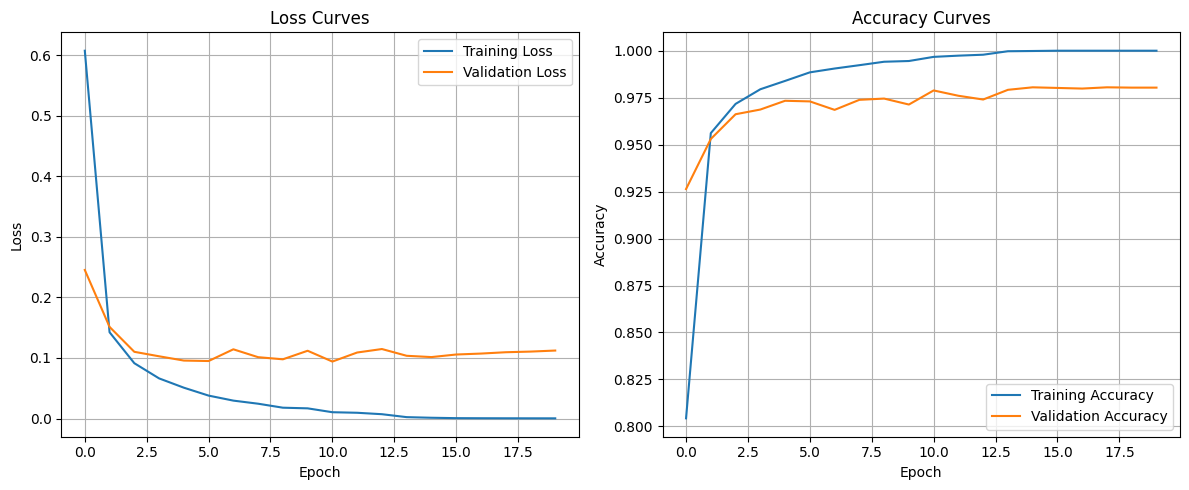

In [54]:
# Plot training and validation loss and accuracy curves
plt.figure(figsize=(12, 5))

# Plot loss curves
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(valid_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.grid(True)

# Plot accuracy curves
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(valid_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [55]:
# Save trained model parameters (weights and biases) to a single NPZ file
np.savez('mlp_params.npz',
         fc1_W=net.fc1.W.data, fc1_b=net.fc1.b.data,
         fc2_W=net.fc2.W.data, fc2_b=net.fc2.b.data,
         fc3_W=net.fc3.W.data, fc3_b=net.fc3.b.data,
         fc4_W=net.fc4.W.data, fc4_b=net.fc4.b.data)
